**GLOBAL CONSTANTS**

In [ ]:
n_var = 3 # Number of input variables (2 geometrical parameters and 1 frequency)
n_output = 6 # Number of output variables (3 complex numbers with 1 imaginary and 1 real part each -> 6 total output variables)
n_latent = 12 # Dimension of latent state
cnn_mode = 'test' # can be "train" when training the CAE, "test" when testing it
dfnn_mode = 'test' # can be "train" when training the DFNN, "test" when testing it
stcnn_mode = 'test' # can be "train" when training the STCNN, "test" when testing it
n_freq = 128 # Number of points in the frequency band

**IMPORTS AND SETTINGS**

In [ ]:
import scipy.io as spio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten
from time import time
from tensorflow import keras
import datetime


In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [ ]:
import random

seed=10
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

**IMPORTING DATA AND PRE-PROCESSING**

In [ ]:
s_data = spio.loadmat('s_data.mat')['s_function_data']

X = s_data[:,0,:n_var].real # Extracting the input parameters. These are all of complex datatype but have imaginary part as 0.
Y = np.zeros((X.shape[0], n_freq, n_output)) # Initialising a numpy array to hold output variables

for i in range(X.shape[0]):
    for freq in range(n_freq): # Assigning the real and imaginary parts of each output variable separately to Y
        Y[i,freq,0] = s_data[i,freq,n_var+0].real
        Y[i,freq,1] = s_data[i,freq,n_var+0].imag
        Y[i,freq,2] = s_data[i,freq,n_var+1].real
        Y[i,freq,3] = s_data[i,freq,n_var+1].imag
        Y[i,freq,4] = s_data[i,freq,n_var+3].real
        Y[i,freq,5] = s_data[i,freq,n_var+3].imag

maxf = 2.25 # Maximum Frequency in GHz
minf = 2.10 # Minimum Frequency in GHz
maxep1 = 77.5 # Maximum value of epsilon 1
minep1 = 76.5 # Minimum value of epsilon 1
maxep2 = 77.5 # Maximum value of epsilon 2
minep2 = 76.5 # Minimum value of epsilon 2

# # NORMALIZATION
X[:,0] = 2.0*(X[:,0] - minf)/(maxf - minf) - 1.0
X[:,1] = 2.0*(X[:,1] - minep1)/(maxep1 - minep1) - 1.0
X[:,2] = 2.0*(X[:,2] - minep2)/(maxep2 - minep2) - 1.0

print(X.shape) # (500,3) Total 500 sets of 2 geometrical parameters along with a frequency
print(Y.shape) # (500,128,6) Total 500 sets of geometrical parameters with 128 frequency steps and 6 output variables



(500, 3)
(500, 128, 6)


**TRAIN, TEST, VAL SPLITS**

In [ ]:
var_samples = X.shape[0] # Total number of points at which data is available = 8192 (64*128)
samples = np.arange(0,var_samples) # Just for shuffling the dataset for better results

train_total = 400 # Total number of training samples
val_total = 50 # Total number of validation samples
test_total = var_samples - train_total - val_total # Total number of testing samples

train_indices = np.array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13, 14,  15,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28, 29,  30,  31,  32,  34,  35,  36,  37,  38,  39,  40,  41,  43, 44,  45,  46,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57, 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  69,  70,  71, 72,  73,  74,  77,  78,  79,  81,  82,  83,  84,  85,  86,  87, 88,  89,  91,  92,  93,  95,  98,  99, 100, 101,
       102, 103, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 135, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 164, 165, 167, 168, 169, 170, 171, 172, 176, 178, 179, 180, 181, 183, 184, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 203, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 218, 220,
       221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 247, 248, 249, 251, 252, 253, 254, 255, 256, 258, 260, 261, 262, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 288, 290, 291, 292, 293, 294, 296, 297, 299, 300, 301, 303, 304, 305, 306, 307, 308, 310, 312, 314, 315, 316, 317, 319, 320, 321, 322, 323, 325, 326, 328, 329, 330,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 362, 363, 364, 365, 367, 368, 369, 370, 371, 373, 375, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 395, 397, 399, 400, 402, 403, 404, 405, 407, 408, 410, 411, 412, 413, 414, 415, 416, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 431, 433, 434, 436, 437, 438, 439, 441, 443, 444, 445, 446,
       447, 448, 451, 452, 453, 454, 455, 456, 457, 460, 461, 462, 464, 465, 466, 467, 468, 470, 471, 472, 473, 474, 475, 476, 480, 481, 484, 485, 486, 489, 491, 492, 493, 494, 495, 496, 497, 498, 499])

test_indices = np.array([ 16,  33,  49,  75,  80,  94,  97, 105, 111, 130, 134, 140, 152, 163, 173, 175, 182, 188, 204, 216, 219, 240, 250, 259, 264, 289, 298, 309, 313, 324, 331, 361, 372, 376, 383, 392, 394, 398, 406, 417, 430, 435, 442, 450, 459, 469, 478, 482, 487, 490])
val_indices = np.array([  8,  17,  42,  68,  76,  90,  96, 104, 110, 119, 133, 136, 145, 158, 166, 174, 177, 187, 202, 208, 217, 225, 246, 257, 263, 287, 295, 302, 311, 318, 327, 332, 366, 374, 377, 391, 393, 396, 401, 409, 429, 432, 440, 449, 458, 463, 477, 479, 483, 488])

maxY = np.max(abs(Y[train_indices]))
meanY = np.mean(Y[train_indices], axis=0)
stdY = np.std(Y[train_indices], axis=0)

Y = (Y - meanY).astype('float32')/stdY # normalization

x_train = X[train_indices]
x_test = X[test_indices]
x_val = X[val_indices]

y_train = Y[train_indices]
y_test = Y[test_indices]
y_val = Y[val_indices]

print(x_train.shape,x_val.shape, y_test.shape)

(400, 3) (50, 3) (50, 128, 6)


**CONVOLUTIONAL AUTOENCODER**

In [ ]:
# IMPORTING DIFFERENT KERAS LAYERS

from tensorflow.keras.layers import Conv1D, Conv2D, TimeDistributed, UpSampling1D, MaxPooling1D, ZeroPadding1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, Cropping1D, Conv1DTranspose, Input, Dropout, Concatenate, AveragePooling1D, Flatten, Dense
from tensorflow.keras.layers import RepeatVector, BatchNormalization, Activation, Add
from tensorflow.keras import optimizers, models, regularizers, Sequential, Model, initializers
from tensorflow.keras import backend as K

# DEFINING A NEW METRIC, COEFFICIENT OF DETERMINATION
def coeff_determination(y_pred, y_true):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
padding = 'same' # padding can be same or valid.
count = 1 # Number of dense layers in the encoder/ decoder
multiplier = 6 # Parameter to control channel depth
activation = 'tanh'

def encoder_block(inputs, channels, kernels, activation, block_name, normalization=False, skip=False):
    with K.name_scope(block_name):
        x = Conv1D(channels[0],kernel_size=kernels[0],activation=None,padding='same')(inputs)
        x = Activation(activation)(x)
        if normalization:
            x = BatchNormalization()(x)

        x = Conv1D(channels[1],kernel_size=kernels[1],activation=None,padding='same')(x)
        x = Activation(activation)(x)
        if normalization:
            x = BatchNormalization()(x)

        if skip:
            added = Add()([x, inputs])
            x = Activation(activation)(added)

    return x

def decoder_block(inputs, channels, kernels, strides, activation, block_name, normalization=False, skip=False):
    with K.name_scope(block_name):
        x = Conv1DTranspose(channels[0],kernel_size=kernels[0],activation=None,padding='same', strides = strides[0])(inputs)
        x = Activation(activation)(x)
        if normalization:
            x = BatchNormalization()(x)

        x = Conv1DTranspose(channels[1],kernel_size=kernels[1],activation=None,padding='same', strides = strides[1])(x)
        x = Activation(activation)(x)
        if normalization:
            x = BatchNormalization()(x)

        if skip:
            added = Add()([x,inputs])
            x = Activation(activation)(added)

    return x

def pooling1D(inputs, channels, kernels, strides, activation, block_name, normalization=False, skip=False):
    with K.name_scope(block_name):
        # x = Conv1D(channels,kernel_size=kernels,activation=None,padding='same', strides = strides)(inputs)
        # if normalization:
        #     x = BatchNormalization()(x)
        # x = Activation(activation)(x)
        x = MaxPooling1D(2)(inputs)

    return x

def unpooling1D(inputs, channels, kernels, strides, activation, block_name,  normalization=False, skip=False):
    with K.name_scope(block_name):
        # x = Conv1DTranspose(channels,kernel_size=kernels,activation=None,padding='same', strides = strides)(inputs)
        # if normalization:
        #     x = BatchNormalization()(x)
        # x = Activation(activation)(x)
        x = UpSampling1D(2)(inputs)

    return x

# ENCODER
encoder_inputs = Input(shape=(n_freq,n_output),name='Field')

enc_11 = Conv1D(6,kernel_size=3,activation=None,padding='same')(encoder_inputs)

if False:
    enc_11 = Activation()(enc_11)
if False:
    enc_11 = BatchNormalization()(enc_11)
x = Conv1D(36,kernel_size=3,activation=None,padding='same')(enc_11)
x = Activation(activation)(x)
if False:
    x = BatchNormalization()(x)

enc_11 = pooling1D(x, 36, 3, 2, activation, 'pool_11')

enc_12 = encoder_block(enc_11, [36, 36], [3,3], activation, 'enc12')
enc_12 = pooling1D(enc_12, 36, 3, 2, activation, 'pool_12')

enc_13 = encoder_block(enc_12, [36, 36], [3,3], activation, 'enc13')
enc_13 = pooling1D(enc_13, 36, 3, 2, activation, 'pool_13')

enc_14 = encoder_block(enc_13, [36, 36], [3,3], activation, 'enc14')
enc_14 = pooling1D(enc_14, 36, 3, 2, activation, 'pool_14')

enc_15 = encoder_block(enc_14, [36, 36], [3,3], activation, 'enc15')
enc_15 = pooling1D(enc_15, 36, 3, 2, activation, 'pool_15')

enc_16 = encoder_block(enc_15, [36, 36], [3,3], activation, 'enc16')
enc_16 = pooling1D(enc_16, 36, 3, 2, activation, 'pool_16')

encoded = Flatten()(enc_16) # Flattening for applying Dense LaFalse

encoded = Dense(72, activation=activation)(encoded)
for i in range(count-1): # Dense layers
  encoded = Dense(72, activation=activation)(encoded)

encoded = Dense(n_latent, activation=activation)(encoded)

for i in range(count-1):
  encoded = Dense(n_latent, activation=activation)(encoded)

# Encoded state
encoder = Model(encoder_inputs, encoded, name="encoder")

# DECODER
decoder_inputs = Input(shape=(n_latent),name='decoded')

if count > 1:
    x = Dense(n_latent, activation=activation)(decoder_inputs)
else:
    x = decoder_inputs

for i in range(count-2):
  x = Dense(n_latent, activation=activation)(x)

x = Dense(72, activation=activation)(x)

for i in range(count):
  x = Dense(72, activation=activation)(x)

x = Reshape((2, n_output*multiplier))(x)

dec_11 = unpooling1D(x, 36, 3, 2, activation, 'unpool_11')

dec_12 = decoder_block(dec_11, [36, 36], [3,3], [1,1], activation, 'dec_12')
dec_12 = unpooling1D(dec_12, 36, 3, 2, activation, 'unpool_12')

dec_13 = decoder_block(dec_12, [36, 36], [3,3], [1,1], activation, 'dec_13')
dec_13 = unpooling1D(dec_13, 36, 3, 2, activation, 'unpool_13')

dec_14 = decoder_block(dec_13, [36, 36], [3,3], [1,1], activation, 'dec_14')
dec_14 = unpooling1D(dec_14, 36, 3, 2, activation, 'unpool_14')

dec_15 = decoder_block(dec_14, [36, 36], [3,3], [1,1], activation, 'dec_15')
dec_15 = unpooling1D(dec_15, 36, 3, 2, activation, 'unpool_15')

dec_16 = decoder_block(dec_15, [36, 36], [3,3], [1,1], activation, 'dec_16')
dec_16 = unpooling1D(dec_16, 36, 3, 2, activation, 'unpool_16')

dec_17 = Conv1D(36,kernel_size=3,activation=None,padding='same')(dec_16)
x = Activation(activation)(dec_17)

dec_18 = Conv1D(36,kernel_size=3,activation=None,padding='same')(x)
x = Activation(activation)(dec_18)
if False:
    x = BatchNormalization()(x)

decoded = Conv1D(6,kernel_size=3,activation=None,padding='same')(x)
if False:
    decoded = Activation(activation)(dec_17)
if False:
    decoded = BatchNormalization()(decoded)

decoder = Model(inputs=decoder_inputs,outputs=decoded) # decoder

# encoder.summary()
# decoder.summary()

**TRAINING**

In [ ]:
## Autoencoder
ae_outputs = decoder(encoder(encoder_inputs))

model = Model(encoder_inputs, ae_outputs)

# model.summary()

model_name = 'autoencoder'

# design network

lrate = 0.001
num_epochs = 1000
batch_size = 32

filepath = model_name

weights_filepath = filepath + '.h5'
model_filepath = filepath +'.keras'

my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='val_coeff_determination', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_coeff_determination', min_delta=0, patience=250, verbose=0, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [checkpoint, earlystopping]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])

t0 = time()

if cnn_mode == 'train':
    try:
        train_history = model.fit(y_train, y_train, epochs=num_epochs, batch_size=batch_size,callbacks=callbacks_list, validation_data=[y_val,y_val])
    except KeyboardInterrupt:
        pass
elif cnn_mode == 'test':
    model.load_weights(weights_filepath)


# Print training time
print('\n feedforward net training time: {} seconds'.format(time()-t0))


 feedforward net training time: 0.048052310943603516 seconds


**PREPARING DATA FOR DFNN**

In [ ]:
encoded_data = encoder(Y) # Getting the encoded data (output for DFNN)
encoded_data = encoded_data.numpy() # Converting list to numpy array
DFNN_input = X[:,1:] # Getting the input (2 geometrical paramteres)

# ASSIGNING THE TRAIN, TEST AND VALIDATION DATASETS
ff_y_train = encoded_data[train_indices]
ff_y_test = encoded_data[test_indices]
ff_y_val = encoded_data[val_indices]

ff_x_train = DFNN_input[train_indices]
ff_x_test = DFNN_input[test_indices]
ff_x_val = DFNN_input[val_indices]

encoded_data.shape, ff_x_train.shape, ff_y_train.shape
#    (64,12)            (40,2)            (40,12)

((500, 12), (400, 2), (400, 12))

**TRAINING DFNN**

In [ ]:
num_hidden_layers = 10 # Number of hidden layers in the DFNN
num_neurons_per_layer = 36 # Number of neurons in each layer
activation = 'tanh'

# FUNCTION TO CREATE THE MODEL
def create_model():

    ff_model = models.Sequential()
    ff_model.add(tf.keras.Input(n_var-1)) # The input layer

    for _ in range(num_hidden_layers): # The hidden layers
        ff_model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=activation,  kernel_initializer='glorot_normal') )

    ff_model.add(tf.keras.layers.Dense(12, activation=None)) # The output layer
    ff_model = Model(inputs=ff_model.inputs, outputs=ff_model.outputs)

    return ff_model


ff_model = create_model()

# ff_model.summary()

# SETTING THE HYPERPARAMETERS
lrate = 0.001
num_epochs = 1000
batch_size = 32

# FILE-NAMING FOR FUTURE REFERENCING
ffmodel_name = 'dfnn'

ff_filepath = ffmodel_name

ff_weights_filepath = ff_filepath + '.h5'
ff_model_filepath = ff_filepath +'.keras'

my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False) # Learning rate scheduler

# DEFINING CHECKPOINTS
checkpoint = ModelCheckpoint(ff_weights_filepath, monitor='val_coeff_determination', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_coeff_determination', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [checkpoint, earlystopping]

# COMPILING THE MODEL
ff_model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])

t0 = time()

if dfnn_mode == 'train': # Training the DFNN
    ff_train_history = ff_model.fit(ff_x_train, ff_y_train, epochs=num_epochs, batch_size=batch_size,callbacks=callbacks_list, validation_data=[ff_x_val,ff_y_val])

elif dfnn_mode == 'test':
    ff_model.load_weights(ff_weights_filepath)
    ff_y_pred = ff_model.predict(ff_x_test)


print('\n feedforward net training time: {} seconds'.format(time()-t0))




2/2 [==============================] - 0s 8ms/step

 feedforward net training time: 0.3686344623565674 seconds


**COMBINING CAE & DFNN**

In [ ]:
n_preds = test_total # Total number of prediction cases
decoder.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination]) # compiling the decoder for making predictions
final_output = decoder.predict(ff_y_pred) # This is the final output of the DFNN + CAE. It is of the shape (20,128,6)

# CONVERTING TO COMPLEX FORM IN A SIMILAR FASHION
final_y_pred_complex = np.zeros(shape=(n_preds,n_freq,n_output//2),dtype=complex)
final_y_complex = np.zeros(shape=(n_preds,n_freq,n_output//2),dtype=complex)

final_output = final_output*stdY+meanY
y_test = y_test*stdY+meanY

coeff_det_cd = np.zeros((n_preds))
loss_cd = np.zeros((n_preds))
new_loss_cd = np.zeros((n_preds))

for i in range(n_preds):
    coeff_det_cd[i] = coeff_determination(tf.convert_to_tensor(final_output[i], dtype=tf.float64), tf.convert_to_tensor(y_test[i], dtype=tf.float64))
    loss_cd[i] = np.mean((final_output[i] - y_test[i])**2)
    new_loss_cd[i] = np.mean(np.sqrt(np.mean((final_output[i] - y_test[i])**2, axis = 0)))

i = 0
while i<n_preds:
  j = 0
  while j<n_output:
    for z in range(n_freq):
      final_y_pred_complex[i,z,j//2] = complex(final_output[i,z,j],final_output[i,z,j+1])
      final_y_complex[i,z,j//2] = complex(y_test[i,z,j],y_test[i,z,j+1])
    j+=2
  i+=1

predictions = final_y_pred_complex

final_y_pred_complex = np.transpose(final_y_pred_complex)
final_y_complex = np.transpose(final_y_complex)
x_axis = np.linspace(2.1, 2.25, 128)

y_test = y_test/stdY - meanY/stdY


2/2 [==============================] - 1s 247ms/step


**RE-FETCHING DATA FOR STCNN**

In [ ]:
s_data = spio.loadmat('s_data.mat')['s_function_data']

X = s_data[:,0,:n_var].real # Extracting the input parameters. These are all of complex datatype but have imaginary part as 0.
Y = np.zeros((X.shape[0], n_freq, n_output)) # Initialising a numpy array to hold output variables

for i in range(X.shape[0]):
    for freq in range(n_freq): # Assigning the real and imaginary parts of each output variable separately to Y
        Y[i,freq,0] = s_data[i,freq,n_var+0].real
        Y[i,freq,1] = s_data[i,freq,n_var+0].imag
        Y[i,freq,2] = s_data[i,freq,n_var+1].real
        Y[i,freq,3] = s_data[i,freq,n_var+1].imag
        Y[i,freq,4] = s_data[i,freq,n_var+3].real
        Y[i,freq,5] = s_data[i,freq,n_var+3].imag

print(X.shape) # (8192,3) Total 64 sets of geometrical parameters with 128 frequency steps and 3 input variables
print(Y.shape) # (8192,6) Total 64 sets of geometrical parameters with 128 frequency steps and 6 output variables

x_train = X[train_indices]
x_test = X[test_indices]
x_val = X[val_indices]

y_train = Y[train_indices]
y_test = Y[test_indices]
y_val = Y[val_indices]

print(x_train.shape,x_val.shape, y_test.shape)


(500, 3)
(500, 128, 6)
(400, 3) (50, 3) (50, 128, 6)


**DEFINING ADDITIONAL LAYERS FOR STCNN**

In [ ]:
import torch
from torch import nn

class addCoords(nn.Module):
    def __init__(self):
        super(addCoords, self).__init__()

    def forward(self, x):
        in_batch, in_ch, in_h, in_w = x.shape
        width_coords = torch.linspace(-1, 1, steps=in_w).to(x.device)
        wc = width_coords.repeat(in_batch, 1, in_h, 1)
        if in_h != 1:
            height_coords = torch.linspace(-1, 1, steps=in_h).view(in_h, -1).to(x.device)
            hc = height_coords.repeat(in_batch, 1, 1, in_w)
            coord_x = torch.cat((x, wc, hc), 1)
        else:
            coord_x = torch.cat((x, wc), 1)
        return coord_x


class addCoords_1D(nn.Module):
    def __init__(self):
        super(addCoords_1D, self).__init__()

    def forward(self, x):
        in_batch, in_ch, in_w = x.shape
        width_coords = torch.linspace(-1, 1, steps=in_w).to(x.device)
        wc = width_coords.repeat(in_batch, 1, 1)
        coord_x = torch.cat((x, wc), 1)
        return coord_x

**DEFINING THE STCNN**

In [ ]:
import os
import torch.nn as nn
import torch.nn.functional as F
import math

cwd = os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class Solenoid_STCNN(nn.Module):
    def __init__(self):
        super(Solenoid_STCNN, self).__init__()

        ##Fully Connected Layers
        self.add_coords = addCoords_1D()
        self.lin1 = nn.Linear(2, 25)
        self.lin2 = nn.Linear(25, 25)
        self.lin3 = nn.Linear(25, 25)
        self.lin4 = nn.Linear(25, 25)
        self.norm_fc = nn.BatchNorm1d(25)
        ##DECODER
        self.tconv1 = nn.ConvTranspose1d(25, 10, 22, 1, 0)
        self.norm_dec1 = nn.BatchNorm1d(10)

        self.tconv2 = nn.ConvTranspose1d(10, 10, 22, 2, 0)
        self.norm_dec2 = nn.BatchNorm1d(10)

        self.tconv3 = nn.ConvTranspose1d(10, 10, 9, 2,  0)
        self.norm_dec3 = nn.BatchNorm1d(10)

        self.tconv4 = nn.ConvTranspose1d(11, 6, 14, 1, 10)

    def fully_connected(self, x):
        latent = self.lin1(x)
        latent = latent.tanh()

        latent = self.lin2(latent)
        latent = latent.tanh()

        latent = self.lin3(latent)
        latent = latent.tanh()

        latent = self.lin4(latent)
        z = (self.norm_fc(latent.view(-1, self.lin4.out_features, 1))).tanh()

        return z

    def transposed_conv(self, z):
        latent = self.tconv1(z)
        latent = latent.tanh()
        latent = self.norm_dec1(latent)

        latent = self.tconv2(latent)
        latent = latent.tanh()
        latent = self.norm_dec2(latent)

        latent = self.tconv3(latent)
        latent = latent.tanh()
        latent = self.norm_dec3(latent)

        latent = self.add_coords(latent)
        recons_y = self.tconv4(latent)
        return recons_y

    def forward(self, x):
        z = self.fully_connected(x)
        out = self.transposed_conv(z)
        return out


**PRE-PROCESSING DATA FOR STCNN**

In [ ]:
import pickle

cwd = os.getcwd()

#Device to be used in training. If GPU is available, it will be automatically used.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Y_new = np.zeros((var_samples,n_output,n_freq))
for i in range(var_samples):
    Y_new[i,0,:] = Y[i,:,0]
    Y_new[i,1,:] = Y[i,:,1]
    Y_new[i,2,:] = Y[i,:,2]
    Y_new[i,3,:] = Y[i,:,3]
    Y_new[i,4,:] = Y[i,:,4]
    Y_new[i,5,:] = Y[i,:,5]

total_y = Y_new
total_x = X[:,1:]

training_x = total_x[train_indices, :]
test_x = total_x[test_indices, :]
val_x = total_x[val_indices, :]

training_y = total_y[train_indices, :, :]
test_y = total_y[test_indices, :, :]
val_y = total_y[val_indices, :, :]

# Get normalization values using Training Data.
meanY = training_y.mean(axis=0)
stdY = training_y.std(axis=0)

MeanY = torch.tensor(meanY).to(device)
StdY = torch.tensor(stdY).to(device)

# Inputs are scaled between [-1, 1].
meanX = training_x.min(axis=0)
stdX = training_x.max(axis=0) - training_x.min(axis=0)

#Normalize Train and Test Data

#Use mean and std of train data to normalize test data to avoid bias
training_x = -1+2*(training_x-meanX)/stdX
training_y = (training_y-meanY)/stdY

test_x = -1+2*(test_x - meanX)/stdX
test_y = (test_y - meanY)/stdY

val_x = -1+2*(val_x - meanX)/stdX
val_y = (val_y - meanY)/stdY

dimIn = training_x.shape[1]

# Convert everything to tensor
tensor_y = torch.Tensor(training_y).to(device)
tensor_x = torch.Tensor(training_x).to(device)

tensor_test_y = torch.Tensor(test_y).to(device)
tensor_test_x = torch.Tensor(test_x).to(device)

tensor_val_y = torch.Tensor(val_y).to(device)
tensor_val_x = torch.Tensor(val_x).to(device)

print('Done loading data and pre-processing.')


Done loading data and pre-processing.


**TRAINNG THE STCNN**

In [ ]:
NMSE_Test = []
stcnnWeights= []
NMSE_Test_Median = []
stcnn = Solenoid_STCNN().to(device)

numParams = sum([p.numel() for p in stcnn.parameters()])

print(f"stcnn is loaded. Number of learnable parameters in the network {numParams:d}")

def calc_training_loss(recon_y, y):
    err = (torch.abs(y-recon_y)**2).sum(dim=2)/recon_y.shape[2]
    return err.sqrt().mean()

def calc_test_NMSE(recon_y, y):
    err = (torch.abs(y-recon_y)**2).sum(dim=2)
    mean_ref = y.mean(dim=2)
    mean_ref = mean_ref.unsqueeze(-1).repeat(1, 1, y.shape[2])
    norm = (torch.abs(y-mean_ref)**2).squeeze().sum(dim=2)
    NMSE = err/norm
    return NMSE

def closure(data_x, data_y):
    optimizer.zero_grad()
    output = stcnn(data_x)
    loss = calc_training_loss(output, data_y)
    return loss


stcnn is loaded. Number of learnable parameters in the network 11695


In [ ]:
if stcnn_mode == 'train':

    test_schedule = 5
    training_iter = 10000
    current_time = time()
    optimizer = torch.optim.Adam(stcnn.parameters(), lr=0.001)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones= [300, 500, 1000, 2500, 3500, 5000, 7000, 9000], gamma=0.5)

    # print(tensor_x.shape, tensor_y.shape)

    for a in range(training_iter):
        stcnn.train()
        train_data_x = tensor_x
        train_data_y = tensor_y
        loss = closure(train_data_x, train_data_y)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        # Set into eval mode for testing.
        if a % test_schedule == 0:
            stcnn.eval()
            with torch.no_grad():
                val_y = tensor_val_y
                val_x = tensor_val_x
                val_output = stcnn(val_x)

                NMSE = calc_test_NMSE(val_output, val_y)
                avNMSE = NMSE.mean()
                medNMSE = NMSE.median()

                print(f"Train Iter {(a+1):d}/{training_iter:d} - Train Loss: {loss.item():.3f} --> "
                    f"Test Av. NMSE: {avNMSE.item():.3f}, Med. NMSE: {medNMSE.item():.3f}")

                #save stcnn weights at each iteration. The best stcnn will be chosen after training is finished.
                stcnnWeights += [stcnn.state_dict()]
                #save test NMSE (both average and median)
                NMSE_Test += [avNMSE.item()]
                NMSE_Test_Median += [medNMSE.item()]

    elapsed = time() - current_time
    print(f"""\n-----------------------------------------------------------------""")
    print(f"""Training is completed in {elapsed :.3f} seconds""")
    NMSE_Test = np.asarray(NMSE_Test)
    best_idx = np.argmin(NMSE_Test)
    final_stcnn_weights = stcnnWeights[best_idx]

    #The weights of the final stcnn will be saved under the name "save_name".
    save_name = "STCNN_Solenoid.pth"
    print(f"Final stcnn Performance on Test Set -> Average NMSE: {100*NMSE_Test[best_idx]:.2f}%, Median NMSE: {100*NMSE_Test_Median[best_idx]:.2f}%.")
    torch.save(final_stcnn_weights, cwd + "/" + save_name)
    print(f"stcnn weights are saved in \"{cwd}\\{save_name}\"")
    print(f"""-----------------------------------------------------------------""")
    print("Exiting.")

elif stcnn_mode == 'test':
    checkpoint = torch.load('STCNN_Solenoid.pth', map_location=torch.device('cpu'))
    stcnn.load_state_dict(checkpoint)
    # stcnn.eval()

**GETTING STCNN RESULTS**

In [ ]:
n_preds = test_total
y_pred = np.zeros((n_preds, n_freq, n_output))
Y_test = np.zeros((n_preds, n_freq, n_output))

t0 = time()

with torch.no_grad():
    test_output = stcnn(tensor_test_x)

t = time()-t0
print('\nNet Prediction time: {} seconds'.format(t))

test_y = tensor_test_y.cpu().numpy()
test_output = test_output.cpu().numpy()

test_y = test_y*stdY + meanY
test_output = test_output*stdY + meanY

for i in range(n_preds):
    y_pred[i,:,0] = test_output[i,0,:]
    y_pred[i,:,1] = test_output[i,1,:]
    y_pred[i,:,2] = test_output[i,2,:]
    y_pred[i,:,3] = test_output[i,3,:]
    y_pred[i,:,4] = test_output[i,4,:]
    y_pred[i,:,5] = test_output[i,5,:]
    Y_test[i,:,0] = test_y[i,0,:]
    Y_test[i,:,1] = test_y[i,1,:]
    Y_test[i,:,2] = test_y[i,2,:]
    Y_test[i,:,3] = test_y[i,3,:]
    Y_test[i,:,4] = test_y[i,4,:]
    Y_test[i,:,5] = test_y[i,5,:]

coeff_det_st = np.zeros((n_preds))
loss_st = np.zeros((n_preds))
new_loss_st = np.zeros((n_preds))

for i in range(n_preds):
    coeff_det_st[i] = coeff_determination(tf.convert_to_tensor(y_pred[i]), tf.convert_to_tensor(Y_test[i]))
    loss_st[i] = np.mean((y_pred[i] - Y_test[i])**2)
    new_loss_st[i] = np.mean(np.sqrt(np.mean((y_pred[i] - Y_test[i])**2, axis = 0)))

y_pred_complex_stcnn = np.zeros(shape=(n_preds,n_freq,n_output//2),dtype=complex) # Initialising array to hold predictions in complex datatype
y_complex = np.zeros(shape=(n_preds,n_freq,n_output//2),dtype=complex) # Initialising array to hold actual true values in complex datatype

# ASSIGNING DATA TO THE COMPLEX ARRAYS
i = 0
while i<n_preds:
  j = 0
  while j<n_output:
    for z in range(n_freq):
      y_pred_complex_stcnn[i,z,j//2] = complex(y_pred[i,z,j],y_pred[i,z,j+1])
      y_complex[i,z,j//2] = complex(Y_test[i,z,j],Y_test[i,z,j+1])
    j+=2
  i+=1

predictions_stcnn = y_pred_complex_stcnn
y_pred_complex_stcnn = np.transpose(y_pred_complex_stcnn) # Taking transpose for further plotting
y_complex = np.transpose(y_complex) # Taking transpose for further plotting
x_axis = np.linspace(2.1, 2.25, 128)
test_y = (test_y - meanY)/stdY



Net Prediction time: 0.343705415725708 seconds


**PRINTING THE RESULTS**

In [ ]:
print('Metric - Minimum | Mean | Maximum')
print(r'R2 for STCNN - {:.4f} | {:.4f} | {:.4f}'.format(np.min(coeff_det_st), np.mean(coeff_det_st), np.max(coeff_det_st)))
print(r'R2 for CAE+DFNN - {:.4f} | {:.4f} | {:.4f}'.format(np.min(coeff_det_cd), np.mean(coeff_det_cd), np.max(coeff_det_cd)))
print(r'MSE for STCNN - {:.4f} | {:.4f} | {:.4f}'.format(np.min(loss_st), np.mean(loss_st), np.max(loss_st)))
print(r'MSE for CAE+DFNN - {:.4f} | {:.4f} | {:.4f}'.format(np.min(loss_cd), np.mean(loss_cd), np.max(loss_cd)))
print(r'Modified MSE for STCNN - {:.4f} | {:.4f} | {:.4f}'.format(np.min(new_loss_st), np.mean(new_loss_st), np.max(new_loss_st)))
print(r'Modified MSE for CAE+DFNN - {:.4f} | {:.4f} | {:.4f}'.format(np.min(new_loss_cd), np.mean(new_loss_cd), np.max(new_loss_cd)))

Metric - Minimum | Mean | Maximum
R2 for STCNN - 0.9289 | 0.9597 | 0.9851
R2 for CAE+DFNN - 0.9890 | 0.9972 | 0.9993
MSE for STCNN - 0.0030 | 0.0082 | 0.0148
MSE for CAE+DFNN - 0.0001 | 0.0006 | 0.0021
Modified MSE for STCNN - 0.0531 | 0.0858 | 0.1168
Modified MSE for CAE+DFNN - 0.0120 | 0.0210 | 0.0455


**PLOTTING THE RESULTS**

In [ ]:
counter = 0

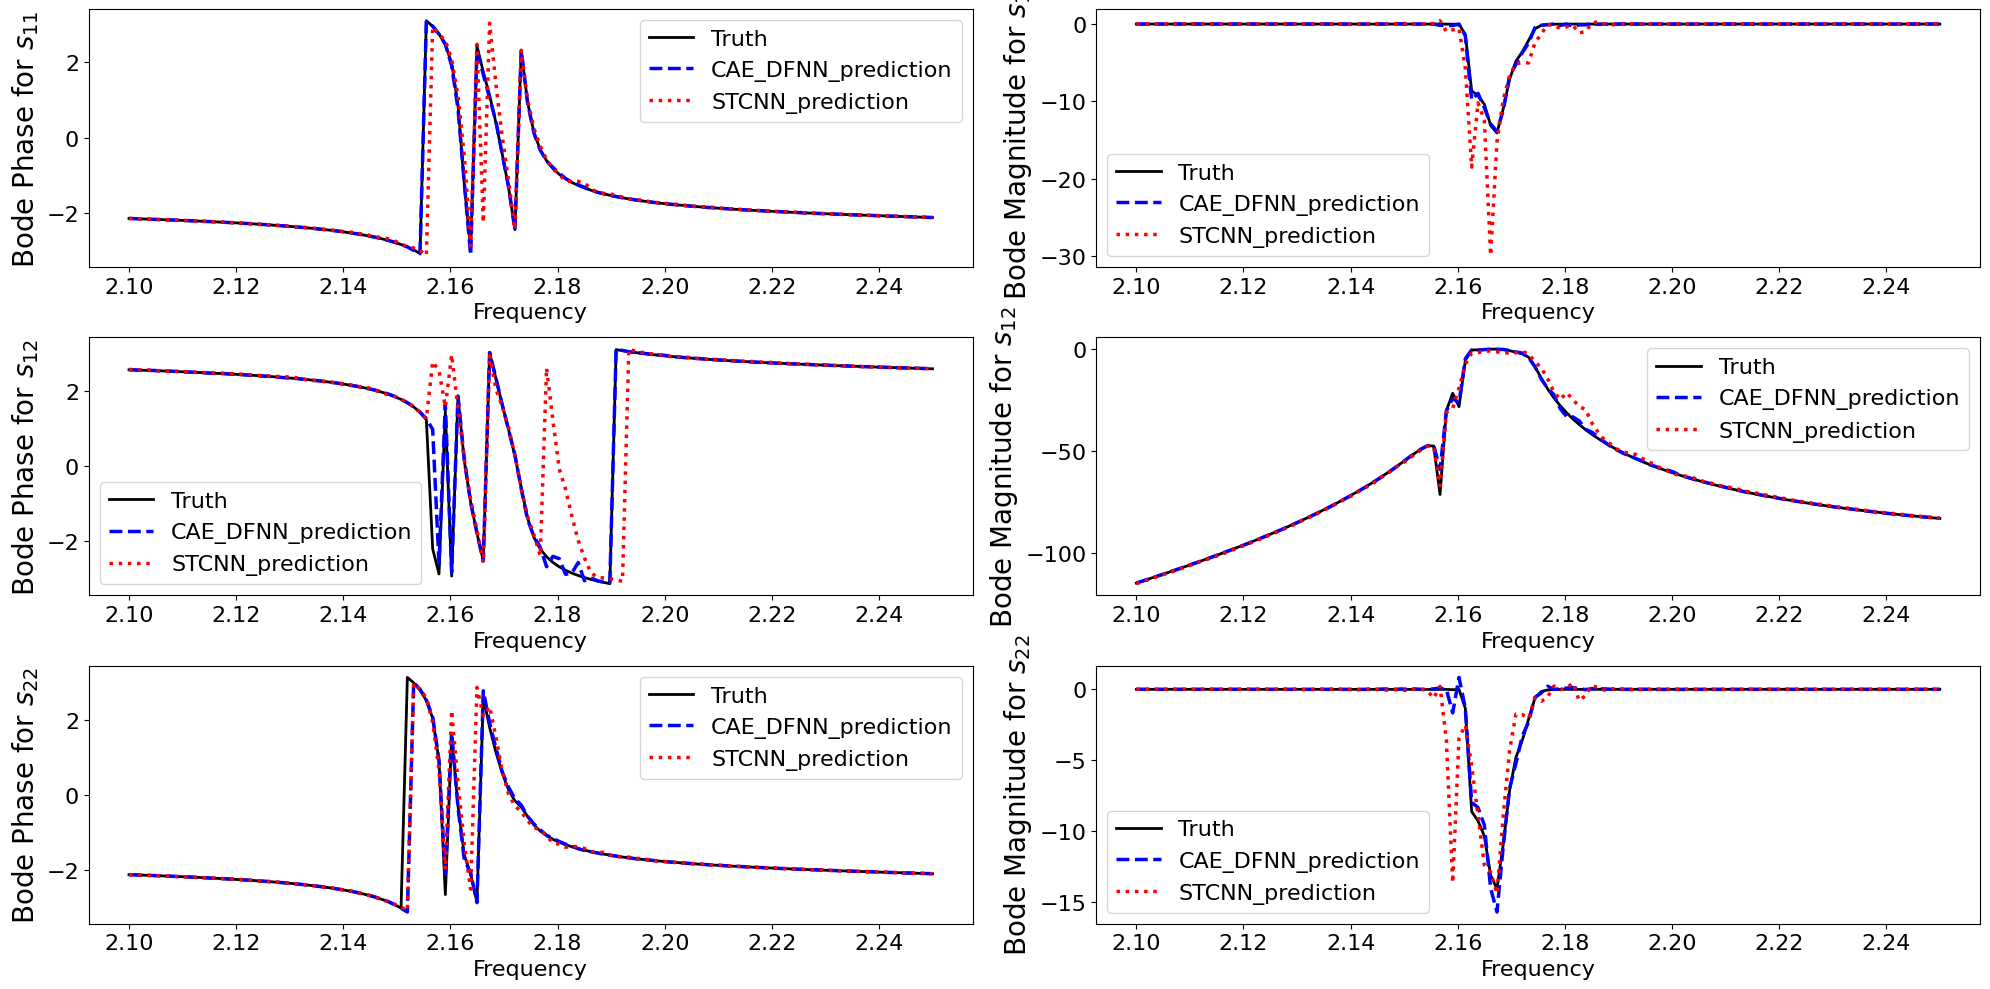

In [ ]:
# PLOTTING THE RESULTS OF THE CAE

# The shape of y_complex and y_pred_complex is (3,128,20) where 3 is the number of output variables, 3 complex numbers, 128 is the number of frequency steps and 20 is the number of testing samples

fig, axs = plt.subplots(n_output//2, 2, figsize=(20, 10))

# THE PLOT BELOW IS GENERATED FOR TESTING SAMPLES. CHANGE SAMPLE TO WHICHEVER INDEX YOU WISH TO PLOT. THE PLOTS BELOW HAVE THE UNNORMALISED FREQUENCY AS THE X AXIS.

counter = 16
sample = counter # change to get plots for different samples
fontsize_1 = '16'
fontsize_2 = '20'
titles = {0: '11', 1: '12', 2:'22'}

# print(counter)

for i in range(n_output//2):

    pos = 0

    axs[i, pos].plot(x_axis,np.angle(y_complex[i,:,sample]),'k',label='Truth', linewidth = '2.0')
    axs[i, pos].plot(x_axis,np.angle(final_y_pred_complex[i,:,sample]), 'b',label='CAE_DFNN_prediction',linewidth = '2.5', linestyle='dashed')
    axs[i, pos].plot(x_axis,np.angle(y_pred_complex_stcnn[i,:,sample]), 'r',label='STCNN_prediction',linewidth = '2.5', linestyle='dotted')
    axs[i, pos].set_xlabel('Frequency', fontsize=fontsize_1)
    axs[i, pos].set_ylabel(r'Bode Phase for $s_{{{}}}$'.format(titles[i]), fontsize=fontsize_2)
    axs[i, pos].tick_params(axis='x', labelsize=fontsize_1)
    axs[i, pos].tick_params(axis='y', labelsize=fontsize_1)
    axs[i, pos].legend(fontsize=fontsize_1)

    pos = 1

    axs[i, pos].plot(x_axis,20*np.log10(np.abs(y_complex[i,:,sample])),'k',label='Truth', linewidth = '2.0')
    axs[i, pos].plot(x_axis,20*np.log10(np.abs(final_y_pred_complex[i,:,sample])), 'b',label='CAE_DFNN_prediction',linewidth = '2.5', linestyle='dashed')
    axs[i, pos].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[i,:,sample])), 'r',label='STCNN_prediction',linewidth = '2.5', linestyle='dotted')
    axs[i, pos].set_xlabel('Frequency', fontsize=fontsize_1)
    axs[i, pos].set_ylabel(r'Bode Magnitude for $s_{{{}}}$'.format(titles[i]), fontsize=fontsize_2)
    axs[i, pos].tick_params(axis='y', labelsize=fontsize_1)
    axs[i, pos].tick_params(axis='x', labelsize=fontsize_1)
    axs[i, pos].legend(fontsize=fontsize_1)


plt.tight_layout()

plt.savefig('sample_plot.png', bbox_inches='tight')

plt.show()

counter += 1

In [ ]:
x_test[16]

array([ 2.1       , 77.15027439, 77.4122067 ])

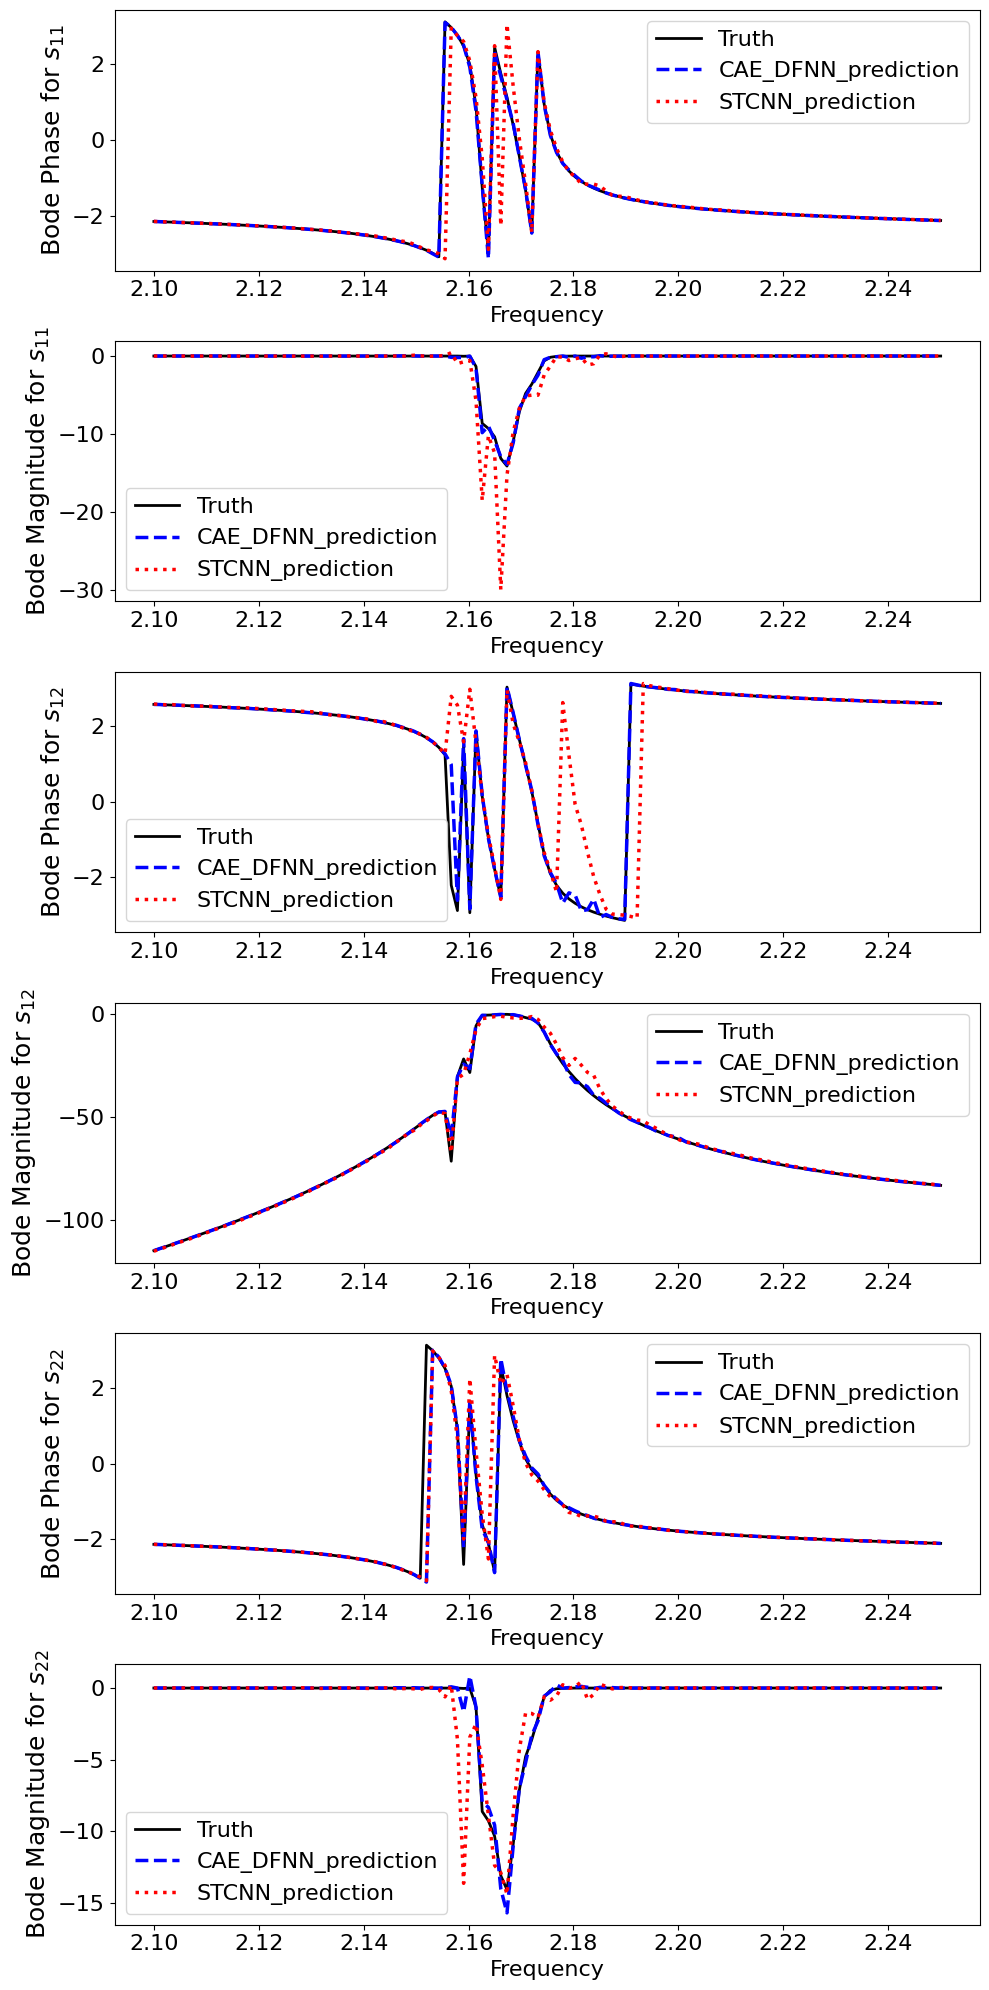

In [ ]:
# PLOTTING THE RESULTS OF THE CAE

# The shape of y_complex and y_pred_complex is (3,128,20) where 3 is the number of output variables, 3 complex numbers, 128 is the number of frequency steps and 20 is the number of testing samples

fig, axs = plt.subplots(n_output, figsize=(10, 20))

sample = 16
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12', 2:'22'}

# print(counter)

for i in range(n_output):

    if i%2 == 0:
        axs[i].plot(x_axis,np.angle(y_complex[i//2,:,sample]),'k',label='Truth', linewidth = '2.0')
        axs[i].plot(x_axis,np.angle(final_y_pred_complex[i//2,:,sample]), 'b',label='CAE_DFNN_prediction',linewidth = '2.5', linestyle='dashed')
        axs[i].plot(x_axis,np.angle(y_pred_complex_stcnn[i//2,:,sample]), 'r',label='STCNN_prediction',linewidth = '2.5', linestyle='dotted')
        axs[i].set_ylabel(r'Bode Phase for $s_{{{}}}$'.format(titles[i//2]), fontsize=fontsize_2)

    else:
        axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[i//2,:,sample])),'k',label='Truth', linewidth = '2.0')
        axs[i].plot(x_axis,20*np.log10(np.abs(final_y_pred_complex[i//2,:,sample])), 'b',label='CAE_DFNN_prediction',linewidth = '2.5', linestyle='dashed')
        axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[i//2,:,sample])), 'r',label='STCNN_prediction',linewidth = '2.5', linestyle='dotted')
        axs[i].set_ylabel(r'Bode Magnitude for $s_{{{}}}$'.format(titles[i//2]), fontsize=fontsize_2)

    axs[i].set_xlabel('Frequency', fontsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_1)


plt.tight_layout()

plt.savefig('Sample_25.png', bbox_inches='tight')

plt.show()



# counter += 1

**PLOTTING SPECIAL CASES WHERE STCNN FAILS**

In [ ]:
# # 500 lhs

false_spike_phase_1 = []

false_spike_phase_2 = [19, 22, 35]

unstable_magnitude_1 = [9, 12, 14, 18, 34, 41]

unstable_magnitude_3 = [33, 34, 41]

false_spike_magnitude_1 = [1, 3, 5, 7, 10, 12, 18, 29, 30, 35, 46, 47, 49]

false_spike_magnitude_3 = [4, 6, 9, 13, 14, 16, 18, 20, 23, 39, 40]

In [ ]:
counter = 0

18


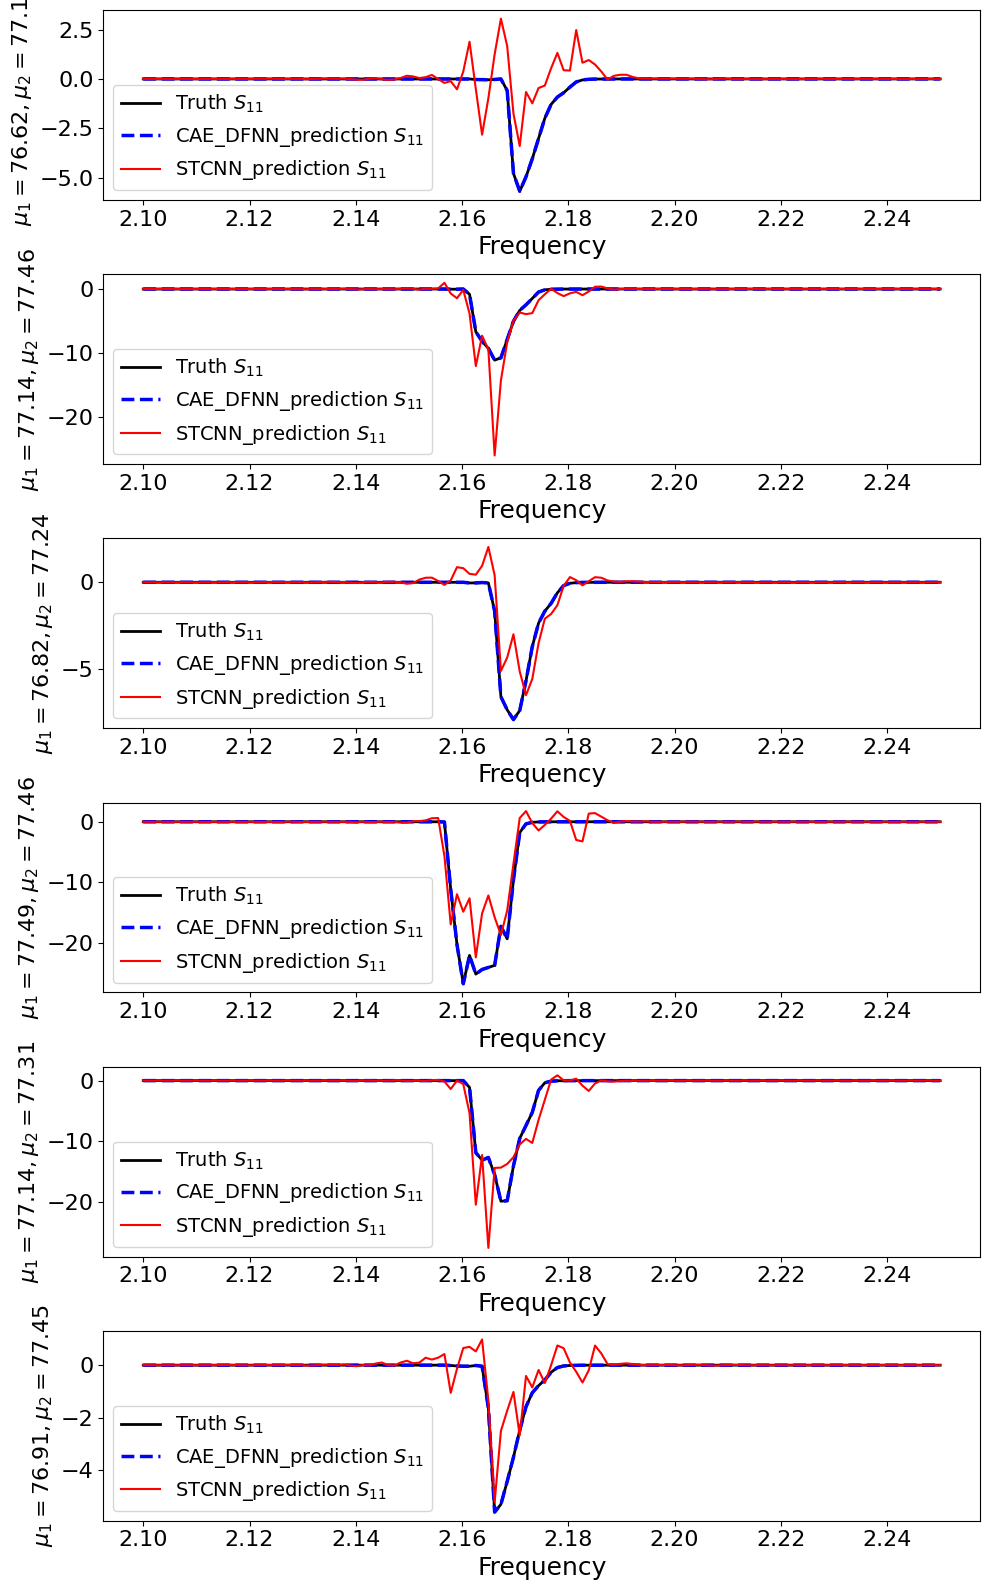

In [ ]:
fontsize = '16'
dim = 0
fontsize_0 = '14'
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12', 2:'22'}

fig, axs = plt.subplots(6, figsize=(10, 16))

print(counter)

for i in range(6):

    sample = counter

    axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[dim,:,sample])),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,20*np.log10(np.abs(final_y_complex[dim,:,sample])), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[dim,:,sample])), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_2)
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_0)
    counter+=1


plt.tight_layout()

# plt.savefig('Spike_Mag_3.png', bbox_inches='tight')

plt.show()


In [ ]:
x_test[19]

array([ 2.1       , 77.1413576 , 77.46097273])

In [ ]:
x_test[5]

array([ 2.1       , 77.30388411, 76.76030447])

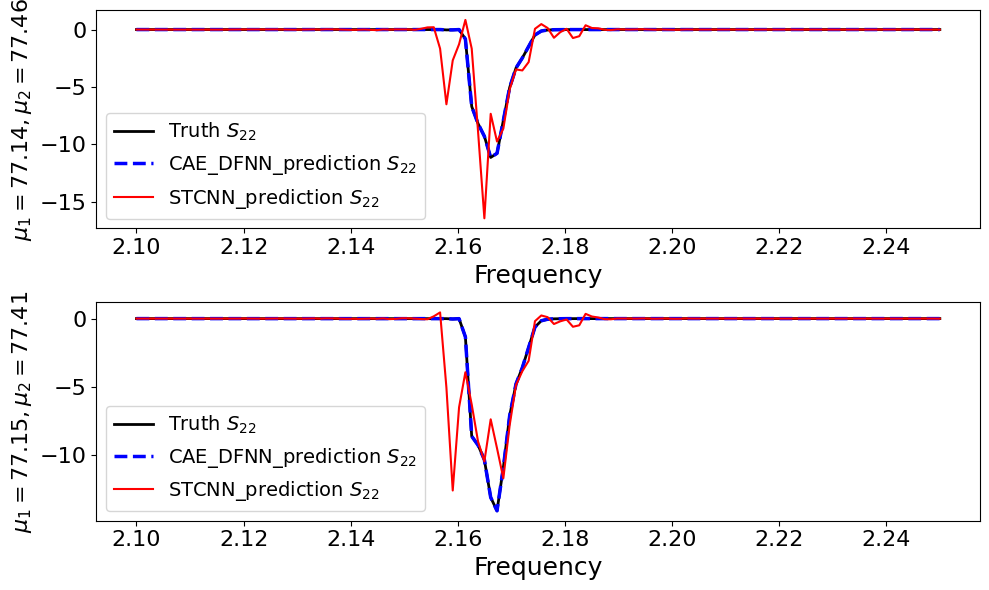

In [ ]:
fontsize = '16'
indices = [19, 23, 9, 40, 16, 34]
indices = [19, 16]
dim = 2
fontsize_0 = '14'
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12', 2:'22'}

fig, axs = plt.subplots(len(indices), figsize=(10, 6))

for i in range(len(indices)):

    sample = indices[i]

    axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[dim,:,sample])),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,20*np.log10(np.abs(final_y_complex[dim,:,sample])), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[dim,:,sample])), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_2)
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_0)


plt.tight_layout()

plt.savefig('Spike_Mag_3.png', bbox_inches='tight')

plt.show()


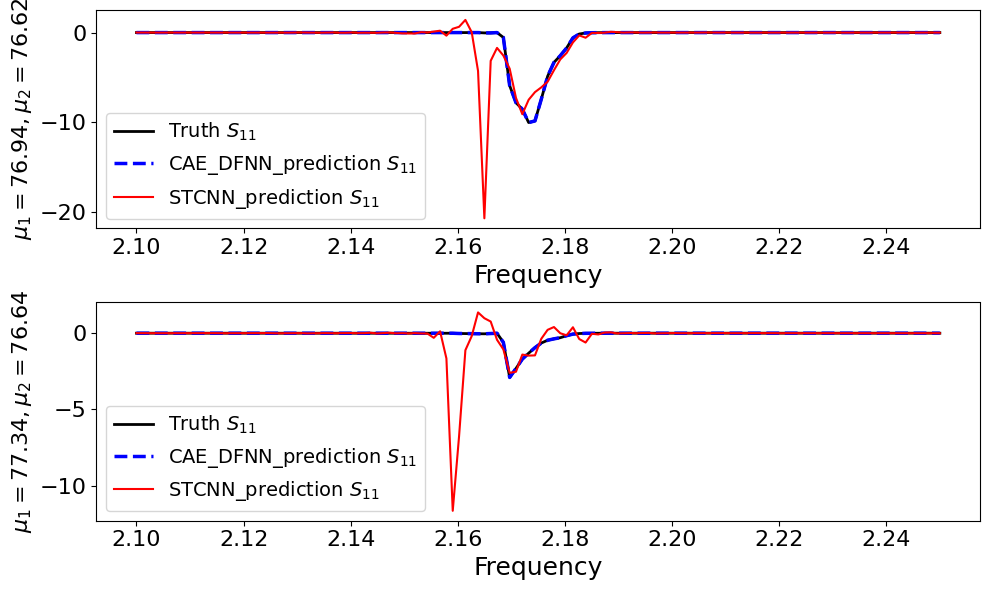

In [ ]:
fontsize = '16'
indices = [1, 4, 30, 7, 24, 12]
indices = [30, 12]
dim = 0
fontsize_0 = '14'
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12', 2:'22'}

fig, axs = plt.subplots(len(indices), figsize=(10, 6))

for i in range(len(indices)):

    sample = indices[i]

    axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[dim,:,sample])),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,20*np.log10(np.abs(final_y_complex[dim,:,sample])), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[dim,:,sample])), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_2)
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_0)


plt.tight_layout()

plt.savefig('Spike_Mag_1.png', bbox_inches='tight')

plt.show()


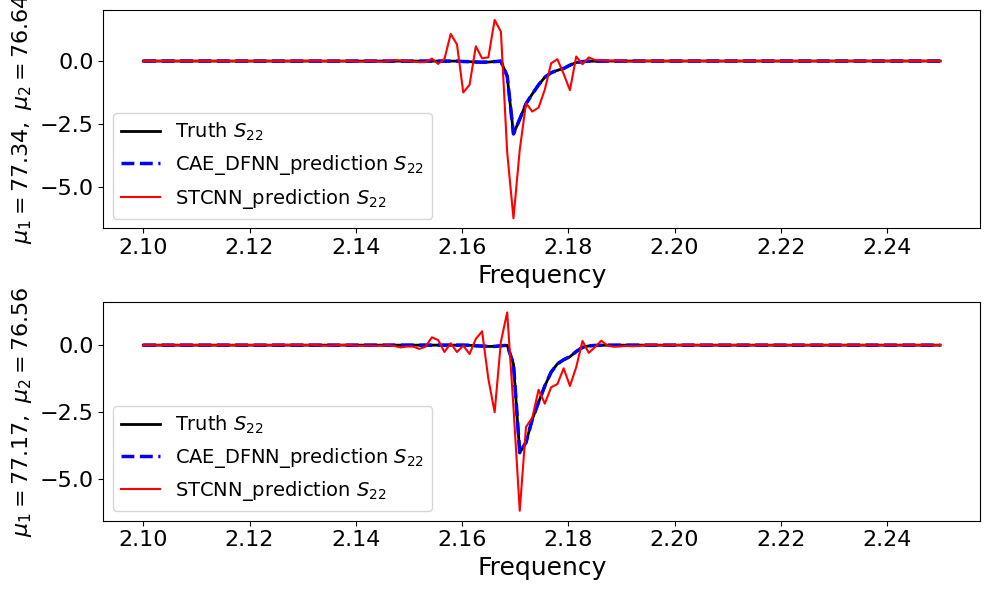

In [ ]:
fontsize = '16'
indices = [3, 4, 12, 23, 34, 41]
indices = [12, 41]
dim = 2
fontsize_0 = '14'
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12', 2:'22'}

fig, axs = plt.subplots(len(indices), figsize=(10, 6))

for i in range(len(indices)):

    sample = indices[i]

    axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[dim,:,sample])),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,20*np.log10(np.abs(final_y_complex[dim,:,sample])), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[dim,:,sample])), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_2)
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \ \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_0)


plt.tight_layout()

plt.savefig('Unstable_Mag_3.png', bbox_inches='tight')

plt.show()


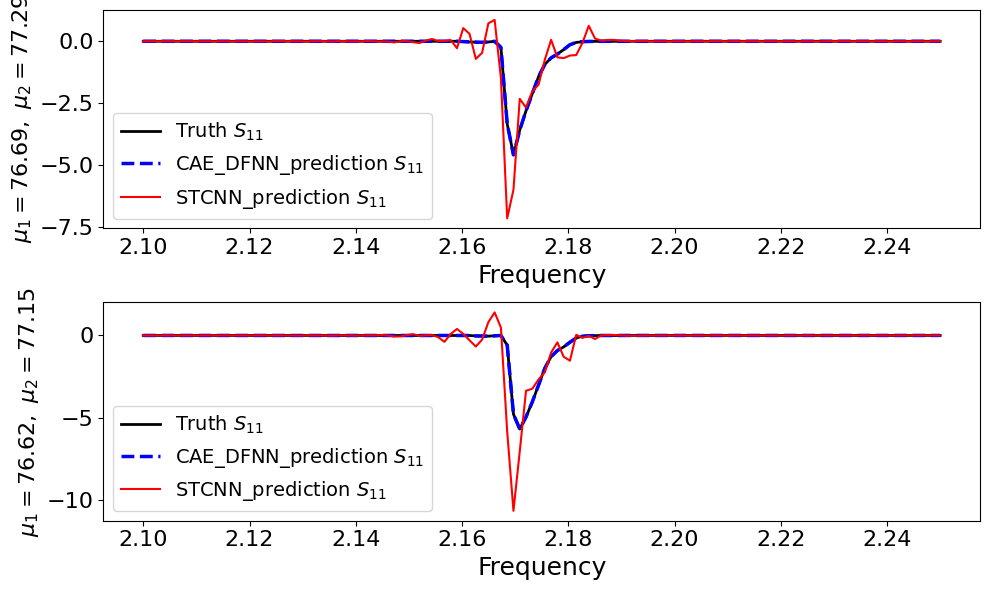

In [ ]:
fontsize = '16'
indices = [4, 9, 14, 18, 23, 34]
indices = [14, 18]
dim = 0
fontsize_0 = '14'
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12'}

fig, axs = plt.subplots(len(indices), figsize=(10, 6))

for i in range(len(indices)):

    sample = indices[i]

    axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[dim,:,sample])),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,20*np.log10(np.abs(final_y_complex[dim,:,sample])), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[dim,:,sample])), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_2)
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \ \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_0)


plt.tight_layout()

plt.savefig('Unstable_Mag_1.png', bbox_inches='tight')

plt.show()


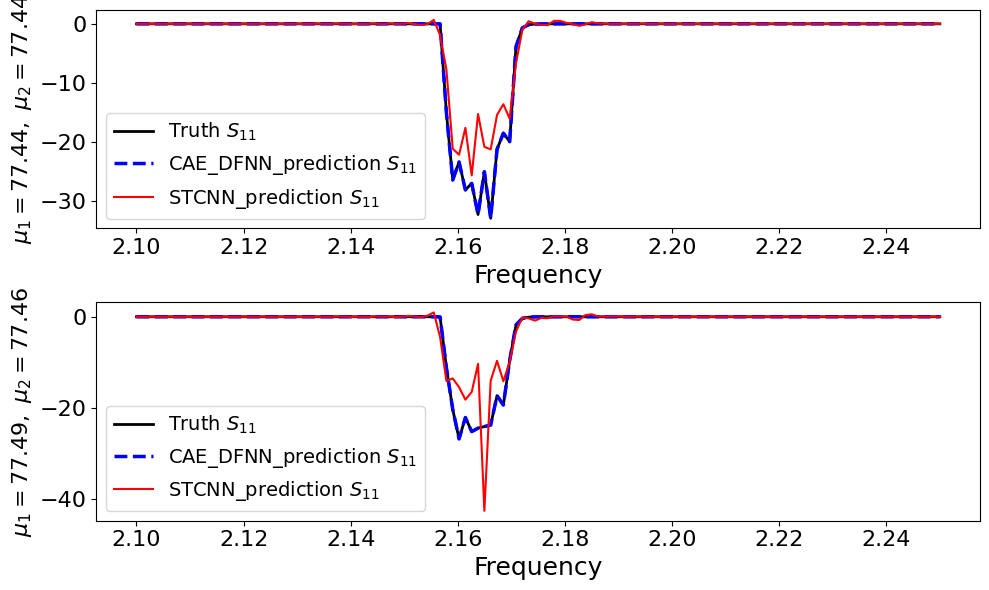

In [ ]:
fontsize = '16'
indices = [11, 17, 21]
indices = [17, 21]
dim = 0
fontsize_0 = '14'
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12'}

fig, axs = plt.subplots(len(indices), figsize=(10, 6))

for i in range(len(indices)):

    sample = indices[i]

    axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[dim,:,sample])),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,20*np.log10(np.abs(final_y_complex[dim,:,sample])), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[dim,:,sample])), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_2)
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \ \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_0)


plt.tight_layout()

plt.savefig('Underestimation_Mag_1.png', bbox_inches='tight')

plt.show()


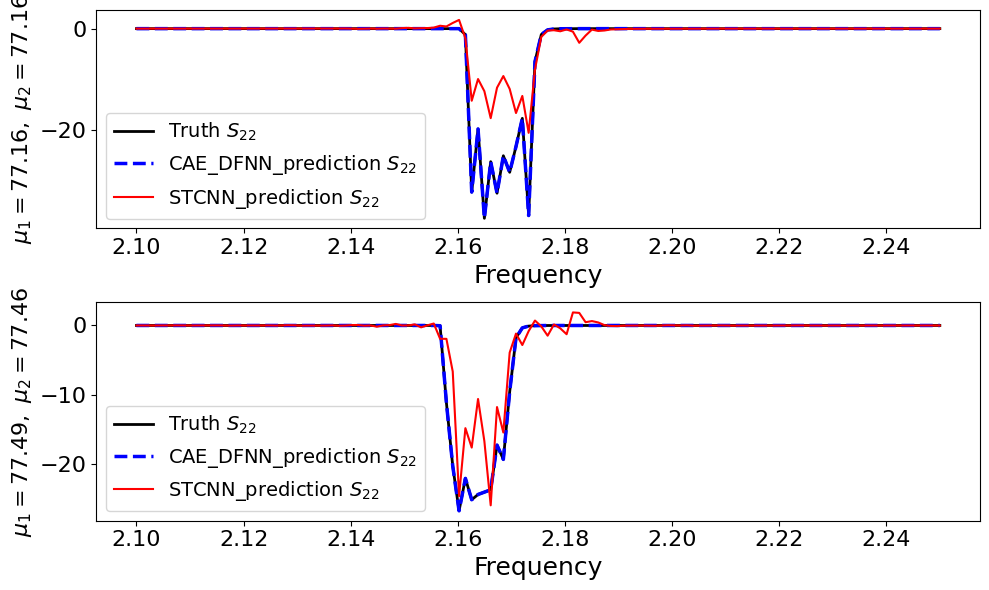

In [ ]:
fontsize = '16'
indices = [25, 2, 8, 11, 17, 21]
indices = [2, 21]
dim = 2
fontsize_0 = '14'
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12', 2:'22'}

fig, axs = plt.subplots(len(indices), figsize=(10, 6))

for i in range(len(indices)):

    sample = indices[i]

    axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[dim,:,sample])),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,20*np.log10(np.abs(final_y_complex[dim,:,sample])), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[dim,:,sample])), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_2)
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \ \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_0)


plt.tight_layout()

plt.savefig('Underestimation_Mag_3.png', bbox_inches='tight')

plt.show()


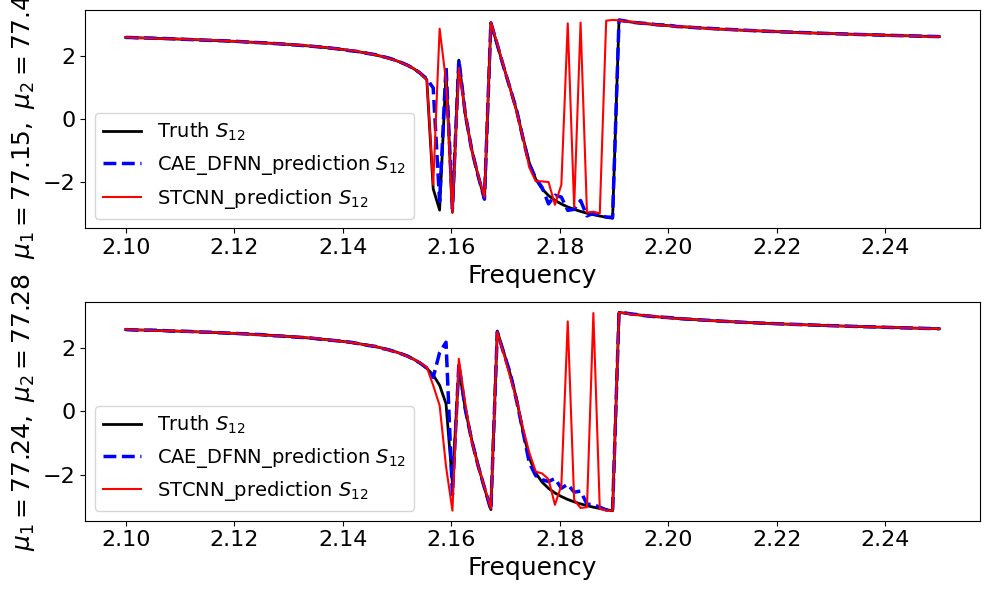

In [ ]:
fontsize = '16'
indices = [16, 19, 22, 25, 35]
indices = [16, 25]
dim = 1
fontsize_0 = '14'
fontsize_1 = '16'
fontsize_2 = '18'
titles = {0: '11', 1: '12'}

fig, axs = plt.subplots(len(indices), figsize=(10, 6))

for i in range(len(indices)):

    sample = indices[i]

    axs[i].plot(x_axis,np.angle(y_complex[dim,:,sample]),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,np.angle(final_y_pred_complex[dim,:,sample]), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,np.angle(y_pred_complex_stcnn[dim,:,sample]), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_2)
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \ \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_2)
    axs[i].tick_params(axis='x', labelsize=fontsize_1)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize=fontsize_0)


plt.tight_layout()

plt.savefig('Spike_Phase_1.png', bbox_inches='tight')

plt.show()


In [ ]:
from matplotlib.ticker import FormatStrFormatter

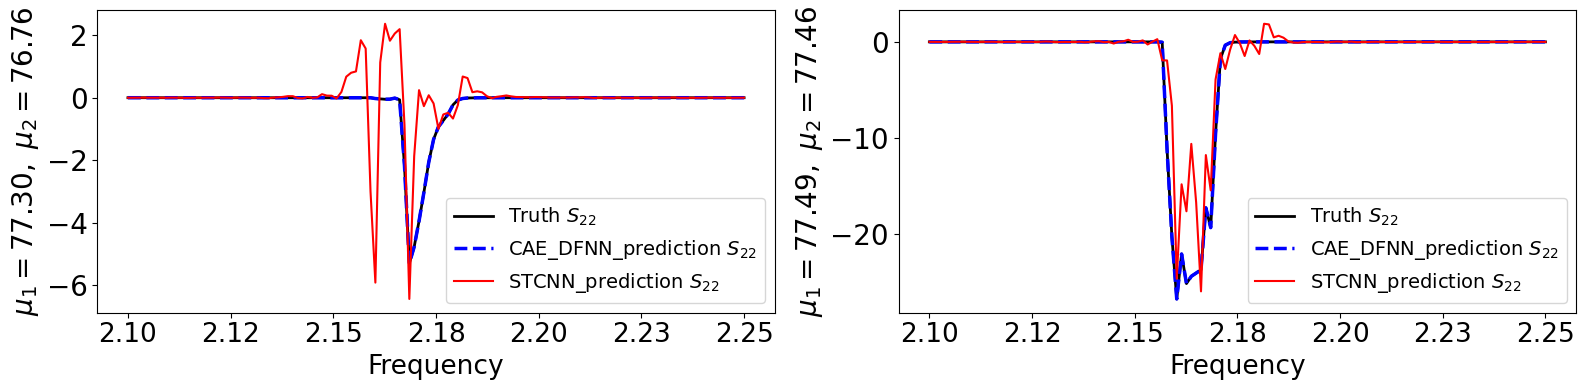

In [ ]:
fontsize = '20'
indices = [5, 21]
dim = 2
fontsize_0 = '19'
fontsize_1 = '20'
fontsize_2 = '28'
titles = {0: '11', 1: '12', 2:'22'}

fig, axs = plt.subplots(1, len(indices), figsize=(16, 4))

for i in range(len(indices)):

    sample = indices[i]

    axs[i].plot(x_axis,20*np.log10(np.abs(y_complex[dim,:,sample])),'k',label=r'Truth $S_{{{}}}$'.format(titles[dim]), linewidth = '2.0')
    axs[i].plot(x_axis,20*np.log10(np.abs(final_y_complex[dim,:,sample])), 'b',label=r'CAE_DFNN_prediction $S_{{{}}}$'.format(titles[dim]),linewidth = '2.5', linestyle='dashed')
    axs[i].plot(x_axis,20*np.log10(np.abs(y_pred_complex_stcnn[dim,:,sample])), 'r',label=r'STCNN_prediction $S_{{{}}}$'.format(titles[dim],linewidth = '2.5', linestyle='dotted'))
    axs[i].set_xlabel('Frequency', fontsize=fontsize_0)
    axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[i].set_ylabel(r'$\mu_1 = {:.2f}, \ \mu_2 = {:.2f}$'.format(X[test_indices[sample],1], X[test_indices[sample],2]), fontsize=fontsize_1)
    axs[i].tick_params(axis='x', labelsize=fontsize_0)
    axs[i].tick_params(axis='y', labelsize=fontsize_1)
    axs[i].legend(fontsize='14', loc='lower right')


plt.tight_layout()

plt.savefig('Errors9.png', bbox_inches='tight')

plt.show()
